In [1]:
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import itertools
from glob import glob

In [16]:
def get_stats(df: pd.DataFrame, y_col: str, method_list: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate R^2 and RMSE statistics for each method in the method list.

    :param df: The input DataFrame containing the data.
    :type df: pd.DataFrame
    :param y_col: The name of the column containing the true values.
    :type y_col: str
    :param method_list: A list of method names to evaluate.
    :type method_list: list[str]
    :return: Two DataFrames containing the R^2 and RMSE values for each method.
    :rtype: tuple[pd.DataFrame, pd.DataFrame]
    """
    r2_list = []
    rmse_list = []
    for k, v in df.groupby("fold"):
        r2_list.append([r2_score(v[y_col], v[x]) for x in method_list])
        rmse_list.append([root_mean_squared_error(v[y_col], v[x]) for x in method_list])
    r2_df = pd.DataFrame(r2_list, columns=method_list)
    rmse_df = pd.DataFrame(rmse_list, columns=method_list)
    r2_melt_df = r2_df.melt()
    r2_melt_df.columns = ["method", "r2"]
    rmse_melt_df = rmse_df.melt()
    rmse_melt_df.columns = ["method", "rmse"]
    return r2_melt_df, rmse_melt_df

def make_boxplots(r2_melt_df: pd.DataFrame, rmse_melt_df: pd.DataFrame) -> None:
    """
    Create boxplots for R^2` and RMSE statistics.

    :param r2_melt_df: DataFrame containing R2 values for each method.
    :type r2_melt_df: pd.DataFrame
    :param rmse_melt_df: DataFrame containing melted RMSE values for each method.
    :type rmse_melt_df: pd.DataFrame
    :return: None
    :rtype: None
    """
    figure, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax0 = sns.boxplot(x="method", y="r2", data=r2_melt_df, ax=axes[0])
    ax0.set_xlabel("Method")
    ax0.set_ylabel("$R^2$")
    ax1 = sns.boxplot(x="method", y="rmse", data=rmse_melt_df, ax=axes[1])
    ax1.set_xlabel("Method")
    ax1.set_ylabel("RMSE")

def evaluate_hsd(df_in: pd.DataFrame, stat_col: str, method_col: str) -> None:
    """
    Evaluate Tukey's Honestly Significant Difference (HSD) test and plot the results.

    :param df_in: Input DataFrame containing the data.
    :type df_in: pd.DataFrame
    :param stat_col: The name of the column containing the statistics to be evaluated.
    :type stat_col: str
    :param method_col: The name of the column containing the method names.
    :type method_col: str
    :return: None
    :rtype: None
    """
    hsd_res = pairwise_tukeyhsd(df_in[stat_col], df_in[method_col])
    print(hsd_res)
    _ = hsd_res.plot_simultaneous(figsize=(5, 3))

def tukey_boxplot(df_in: pd.DataFrame, x_col: str, y_col: str, x_label: str, y_label: str, ax: plt.Axes, title: str = "", hide_ns=False) -> None:
    """
    Create a boxplot with Tukey's Honestly Significant Difference (HSD) test annotations.

    :param df_in: Input DataFrame containing the data.
    :type df_in: pd.DataFrame
    :param x_col: The name of the column to be used for the x-axis.
    :type x_col: str
    :param y_col: The name of the column to be used for the y-axis.
    :type y_col: str
    :param x_label: The label for the x-axis.
    :type x_label: str
    :param y_label: The label for the y-axis.
    :type y_label: str
    :param ax: The matplotlib Axes object where the plot will be drawn.
    :type ax: plt.Axes
    :param title: The title of the plot.
    :type title: str
    :param hide_ns: Don't show "ns" for non-significant comparison
    :type hide_ns: bool
    :return: None
    :rtype: None
    """
    tukey = pairwise_tukeyhsd(endog=df_in[y_col], groups=df_in[x_col], alpha=0.05)
    t_data = tukey._results_table.data
    if hide_ns:
        pairs = [(x[0],x[1]) for x in t_data[1:] if x[3] < 0.05]
        p_vals = [x[3] for x in t_data[1:] if x[3] < 0.05]
    else:        
        pairs = [(x[0],x[1]) for x in t_data[1:]]
        p_vals = [x[3] for x in t_data[1:]]
    ax = sns.boxplot(x=x_col, y=y_col, data=df_in, ax=ax,color="lightblue")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    if True:
        annotator = Annotator(ax, pairs, data=df_in, x=x_col, y=y_col, verbose=False)
        annotator.configure(text_format='star', loc='inside')
        _ = annotator.set_pvalues_and_annotate(p_vals)

Compare molecular descriptors and ML models on the [Polaris biogen/adme-fang-v1](https://polarishub.io/datasets/biogen/adme-fang-v1) dataset.  Benchmark was run using the script **run_benchmark.py** in this repo.  

In the figures below I show 3 model/descriptor combinations. 

lgbm_prop - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with RDKit properties  
lgbm_osm - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with [Osmordred](https://github.com/osmoai/osmordred) properties   
tabpfn - [TabPFN](https://github.com/PriorLabs/TabPFN) with RDKit proprties  

I also calculated two more models, but omitted those from the plots for simplicity. 

chemprop - [ChemProp](https://chemprop.readthedocs.io/en/latest/) with default parameters  
lgbm_morgan - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) with RDKit Morgan fingerprints   

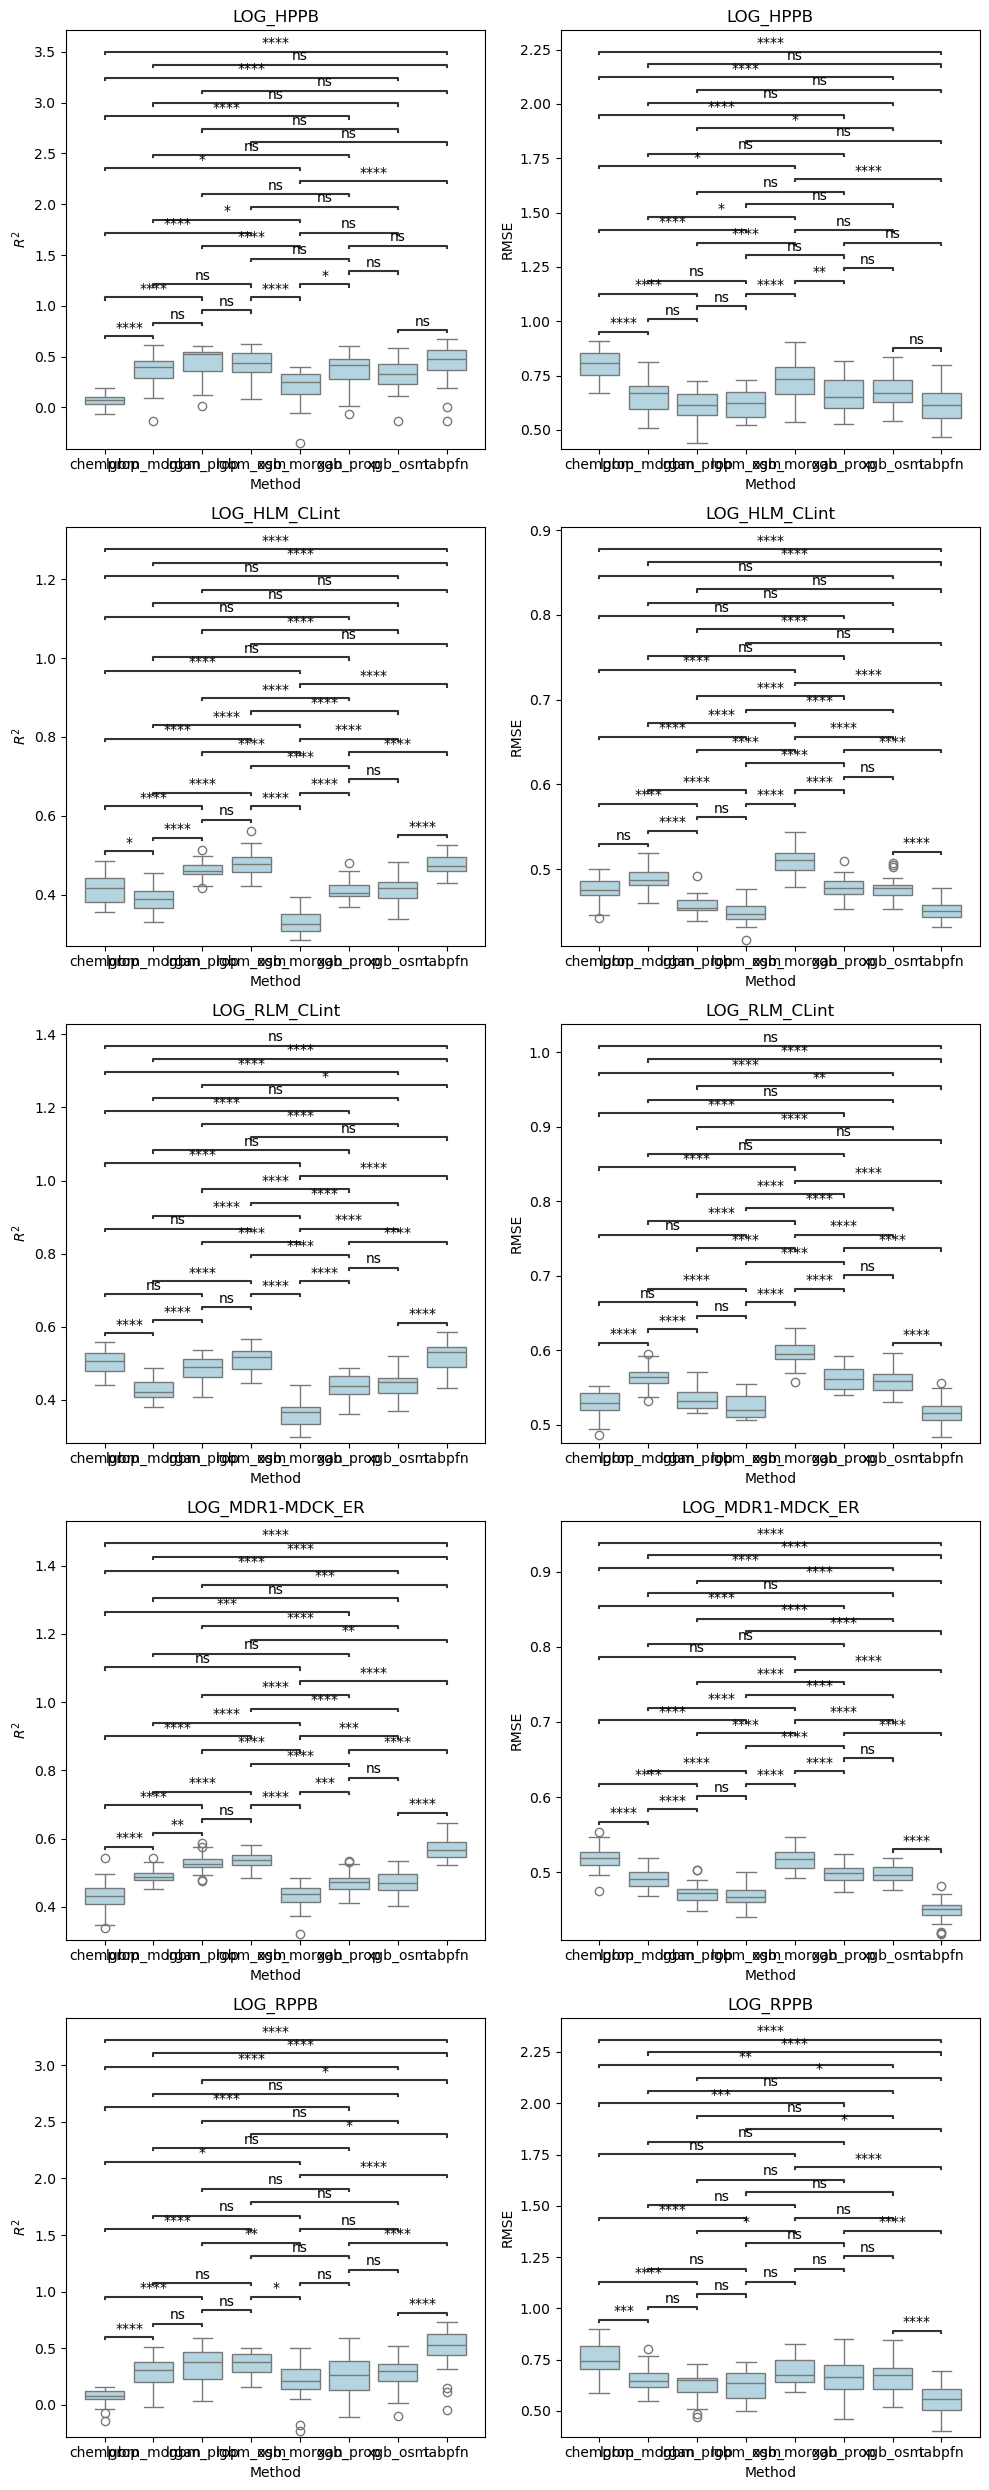

In [18]:
def main():
    #method_list = ['lgbm_prop','xgb_prop','tabpfn']
    method_list = ['chemprop', 'lgbm_morgan', 'lgbm_prop', 'lgbm_osm', 'xgb_morgan', 'xgb_prop', 'xgb_osm', 'tabpfn']
    #method_list = ["chemprop", "lgbm_morgan", "tabpfn","lgbm_prop","lgbm_osm"]
    #method_list = ["lgbm_prop","lgbm_osm","tabpfn"]
    assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
    figure, axes = plt.subplots(len(assay_list),2,figsize=(10,5*len(assay_list)))
    axes = axes.flatten()
    assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
    for idx,assay_name in enumerate(assay_list):
        input_df = pd.read_csv(f"{assay_name}_results.csv")
        input_df = input_df[method_list+["dset","group","fold",assay_name]]
        test_df = input_df.query("dset == 'test' and group == 'random'")
        r2_melt_df, rmse_melt_df = get_stats(test_df,assay_name, method_list)
        tukey_boxplot(r2_melt_df,"method", "r2", "Method", "$R^2$",axes[idx*2],assay_name,hide_ns=False)
        tukey_boxplot(rmse_melt_df,"method", "rmse", "Method", "RMSE",axes[idx*2+1],assay_name,hide_ns=False)
    plt.tight_layout()

main()

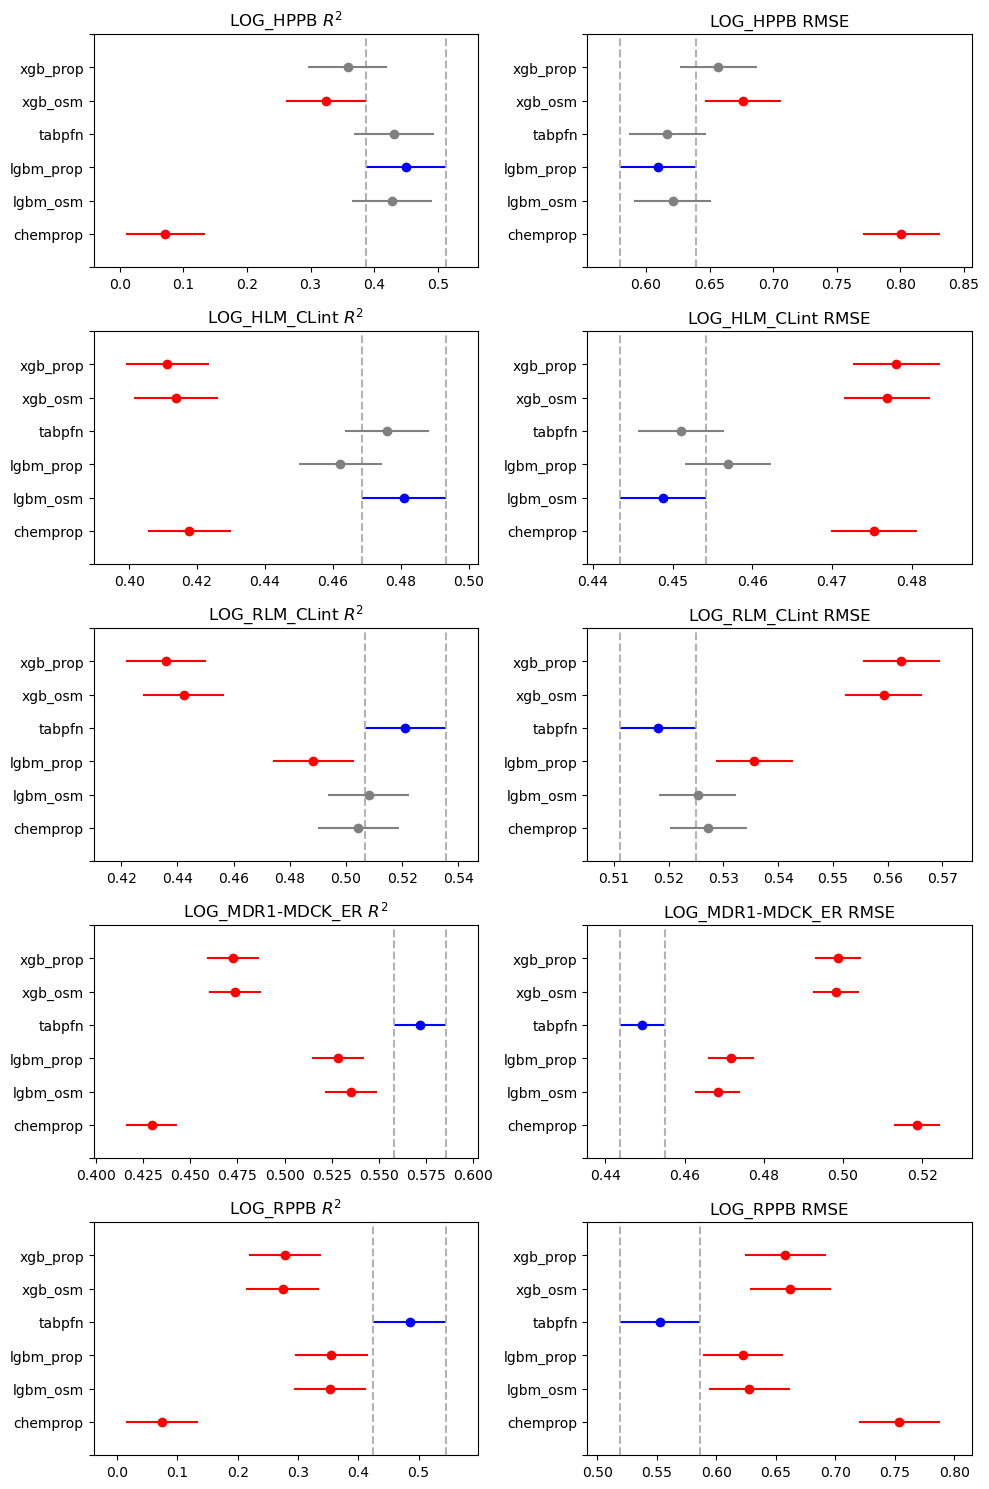

In [12]:
assay_list = [x.replace("_results.csv","") for x in glob("*results.csv")]
figure, axes = plt.subplots(len(assay_list),2,figsize=(10,100))
axes = axes.flatten()
for idx,assay_name in enumerate(assay_list):
    input_df = pd.read_csv(f"{assay_name}_results.csv")
    method_list = ['chemprop','lgbm_prop', 'lgbm_osm','xgb_prop', 'xgb_osm', 'tabpfn']
    input_df = input_df[method_list+["dset","group","fold",assay_name]]
    test_df = input_df.query("dset == 'test' and group == 'random'")
    r2_melt_df, rmse_melt_df = get_stats(test_df,assay_name, method_list)
    best_r2 = r2_melt_df.groupby("method").mean().reset_index().sort_values("r2",ascending=False).method.values[0]
    tukey = pairwise_tukeyhsd(endog=r2_melt_df["r2"], groups=r2_melt_df["method"], alpha=0.05)
    current_axis = axes[idx*2]
    tukey.plot_simultaneous(comparison_name=best_r2,ax=current_axis,figsize=(10,15))
    current_axis.set_title(assay_name+" $R^2$")

    best_rmse = rmse_melt_df.groupby("method").mean().reset_index().sort_values("rmse",ascending=True).method.values[0]
    tukey = pairwise_tukeyhsd(endog=rmse_melt_df["rmse"], groups=rmse_melt_df["method"], alpha=0.05)
    current_axis = axes[idx*2+1]
    tukey.plot_simultaneous(comparison_name=best_rmse,ax=current_axis,figsize=(10,15))
    current_axis.set_title(assay_name+" RMSE")
plt.tight_layout()